<a href="https://colab.research.google.com/github/FLjv77/Quantum_ML_Course/blob/main/codes/ErrorCorrection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Installation

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 82.2 MB/s eta 0:00:00


###Imports

In [2]:
import pennylane as qml
from pennylane import numpy as np

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


###Const Values

In [3]:
ideal = np.array([np.cos(np.pi/8), np.sin(np.pi/8)])


###Utilites

In [4]:
def getFidelity(state1, state2):
  return np.dot(state1, state2) ** 2

###Noise

In [5]:
def error_type1(num, p):
  for i in range(num):
    if np.random.rand() < p:
      qml.X(wires = [i])
  return qml.state

def error_type2(num, p):
  for i in range(num):
    if np.random.rand() < p:
      qml.Z(wires = [i])
  return qml.state

def error_type3(p):
  for i in range(9):
    if(np.random.rand() < p):
      qml.PauliX(wires=i)

  return qml.state

###Circuits

####A Bit Error

In [6]:
dev = qml.device("default.mixed", wires=3)
@qml.qnode(dev)
def bitflip_code(p, num):
  #Init state
  qml.RY(np.pi/4, wires=0)

  #Encode
  qml.CNOT(wires = [0, 1])
  qml.CNOT(wires = [0, 2])

  #Noise
  error_type1(num, p)

  #Decode
  qml.CNOT(wires = [0, 1])
  qml.CNOT(wires = [0, 2])
  qml.Toffoli(wires = [1, 2, 0])

  return qml.probs(wires=0)

@qml.qnode(dev)
def phaseflip_code(p, num):
  #Init state
  qml.RY(np.pi/4, wires=0)

  #Encode
  qml.CNOT(wires = [0, 1])
  qml.CNOT(wires = [0, 2])
  for i in [0, 1, 2]:
    qml.H(i)

  #Noise
  error_type2(num, p)

  #Decode
  for i in [0, 1, 2]:
    qml.H(i)

  qml.CNOT(wires = [0, 1])
  qml.CNOT(wires = [0, 2])
  qml.Toffoli(wires = [1, 2, 0])

  return qml.probs(wires=0)

Fidelity: 0.49999999999999944
(<Figure size 1200x400 with 1 Axes>, <Axes: >)


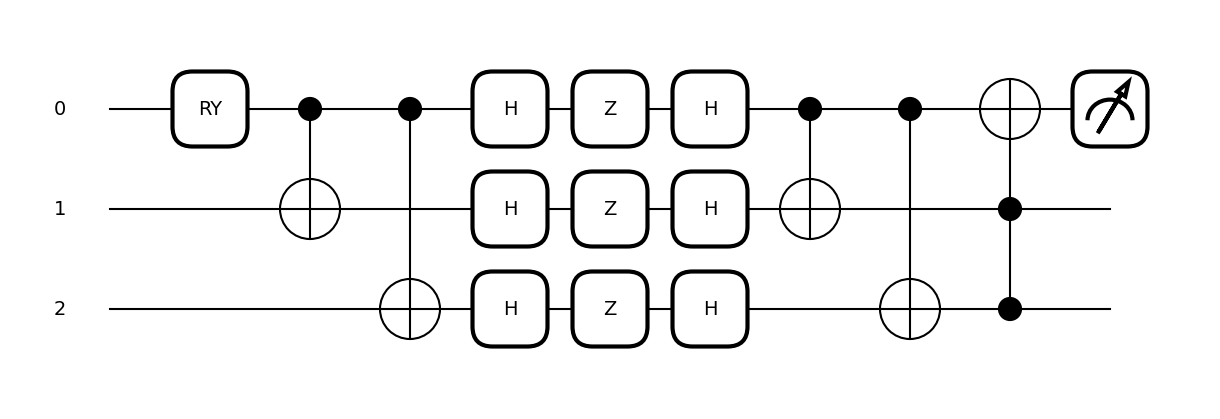

In [7]:
p = 0.99
num = 3
result = phaseflip_code(p, num)
fidelity = getFidelity(np.sqrt(result), (ideal))
print("Fidelity:", fidelity)
print(qml.draw_mpl(phaseflip_code)(p, num))

####Multi Bit Error

In [8]:
dev = qml.device("default.qubit", wires=9)

@qml.qnode(dev)
def shor_code(p):
  #Init state
  qml.RY(np.pi/4, wires=0)

  #Encode
  qml.CNOT(wires=[0, 3])
  qml.CNOT(wires=[0, 6])
  for i in [0, 1, 2]:
      t = i * 3
      qml.Hadamard(wires=t)
      qml.CNOT(wires=[t, t+1])
      qml.CNOT(wires=[t, t+2])

  #Noise
  error_type3(p)

  #Decode
  for i in [0, 1, 2]:
      t = i * 3
      qml.CNOT(wires=[t, t+1])
      qml.CNOT(wires=[t, t+2])
      qml.Toffoli(wires=[t+1, t+2, t])
      qml.Hadamard(wires=t)

  qml.CNOT(wires=[0, 3])
  qml.CNOT(wires=[0, 6])
  qml.Toffoli(wires=[6, 3, 0])

  return qml.probs(wires=0)


In [9]:
for i in range(50):
  ideal = np.array([np.cos(np.pi/8), np.sin(np.pi/8)])
  result = shor_code(0.99)
  fidelity = getFidelity(np.sqrt(result), (ideal))
  print("Fidelity:", fidelity)

Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.9999999999999991
Fidelity: 0.99